## Can we categorize users?
In notebook 04_02, we analyzed user behavior and identified individual user sessions. Now we want to investigate whether we can categorize users based on the features we have available. As a first step, we create features for these categories.

**Note: This notebook is highly experimental, not properly documented and not finished. Therefore its not used in the final analysis!**

In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from matplotlib.colors import LogNorm

from utils import setup_pandas, setup_plotting

setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


# load and prepare data
identical to 04_02_eda_user_behavior

"df_user_sessions" contains the prepared data for further analysis

In [2]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"
LATE_FLAG_COL = "Verspätet"
MEDIA_TYPE_COL = "Medientyp"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")

# --- analyze learning effect over time ---
df_user_sessions = borrowings.copy()

# define a borrowing "session" as same user + same issue timestamp
df_user_sessions["issue_session"] = df_user_sessions[ISSUE_COL].dt.floor("D")  # change to ISSUE_COL

# ngroup is global; convert to per-user consecutive numbering
df_user_sessions["session_index"] = (
    df_user_sessions
    .groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)

basic features

In [3]:
MEDIA = "Medientyp"
CCODE = "CCODE"
EXT = "Anzahl_Verlängerungen"
LATE_BOOL = "late_bool"
DAYS_LATE = "Tage_zu_spät"
LOAN_DUR = "Leihdauer"

data_frame = df_user_sessions.copy()

data_frame["issue_session"] = pd.to_datetime(data_frame[ISSUE_COL]).dt.floor("D")

data_frame["ext"] = pd.to_numeric(data_frame[EXT], errors="coerce").fillna(0)
data_frame["days_late_pos"] = pd.to_numeric(data_frame[DAYS_LATE], errors="coerce").fillna(0).clip(lower=0)
data_frame["loan_dur"] = pd.to_numeric(data_frame[LOAN_DUR], errors="coerce")

user_base = (
    data_frame.groupby(USER_ID_COL)
    .agg(
        n_loans=(LATE_BOOL, "size"),
        n_sessions=("issue_session", "nunique"),
        late_rate=(LATE_BOOL, "mean"),
        pct_ext_ge_1=("ext", lambda s: (s >= 1).mean()),
        #mean_ext=("ext", "mean"),
        mean_loan_dur=("loan_dur", "mean"),
        #p90_loan_dur=("loan_dur", lambda s: np.nanpercentile(s.dropna(), 90) if s.notna().any() else np.nan),
        #p90_days_late_if_late=("days_late_pos", lambda s: np.percentile(s[s>0], 90) if (s>0).any() else 0.0),
    )
    .reset_index()
)

sess_sizes = (
    data_frame.groupby([USER_ID_COL, "issue_session"]).size().rename("items_in_session").reset_index()
)
user_sess = (
    sess_sizes.groupby(USER_ID_COL)["items_in_session"]
    .agg(
        mean_items_per_session="mean",
        #p90_items_per_session=lambda s: np.percentile(s, 90)
        )
    .reset_index()
)

user_features = user_base.merge(user_sess, on=USER_ID_COL, how="left")
user_features.head()


,Benutzer-Systemnummer,n_loans,n_sessions,late_rate,pct_ext_ge_1,mean_loan_dur,mean_items_per_session
0,46,2,2,0.5000,0.0000,29.0000,1.0000
1,50,978,611,0.0020,0.3937,32.5982,1.6007
2,51,22,13,0.0000,0.1364,16.6364,1.6923
3,53,5,2,0.0000,0.8000,48.4000,2.5000
4,54,957,227,0.0209,0.6217,58.0230,4.2159


add category features

In [4]:
TOP_K_MEDIA = 6

top_media = data_frame[MEDIA].value_counts().head(TOP_K_MEDIA).index

media_share = (
    data_frame[data_frame[MEDIA].isin(top_media)]
    .assign(cnt=1)
    .pivot_table(index=USER_ID_COL, columns=MEDIA, values="cnt", aggfunc="sum", fill_value=0)
)

media_share = media_share.div(media_share.sum(axis=1), axis=0)
media_share.columns = [f"share_media__{c}" for c in media_share.columns]

user_features = user_features.merge(media_share.reset_index(), on=USER_ID_COL, how="left").fillna(0)

user_features = user_features[user_features["n_loans"] >= 20].copy()

def add_topk_shares(user_df, raw_df, user_col, cat_col, topk=10, prefix=None):
    prefix = prefix or cat_col
    top = raw_df[cat_col].value_counts().head(topk).index

    mat = (
        raw_df[raw_df[cat_col].isin(top)]
        .assign(cnt=1)
        .pivot_table(index=user_col, columns=cat_col, values="cnt", aggfunc="sum", fill_value=0)
    )
    mat = mat.div(mat.sum(axis=1), axis=0)  # shares
    mat.columns = [f"share_{prefix}__{c}" for c in mat.columns]

    old = [c for c in user_df.columns if c.startswith(f"share_{prefix}__")]
    user_df = user_df.drop(columns=old, errors="ignore")

    return user_df.merge(mat.reset_index(), on=user_col, how="left").fillna(0)

user_features = add_topk_shares(
    user_features, df_user_sessions, USER_ID_COL, "Benutzerkategorie", topk=2, prefix="usercat"
)

user_features = add_topk_shares(
    user_features, df_user_sessions, USER_ID_COL, "Interessenkreis", topk=5, prefix="interest"
)

Explained variance: [0.20740165 0.11880938]


/tmp/ipykernel_175125/697604620.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


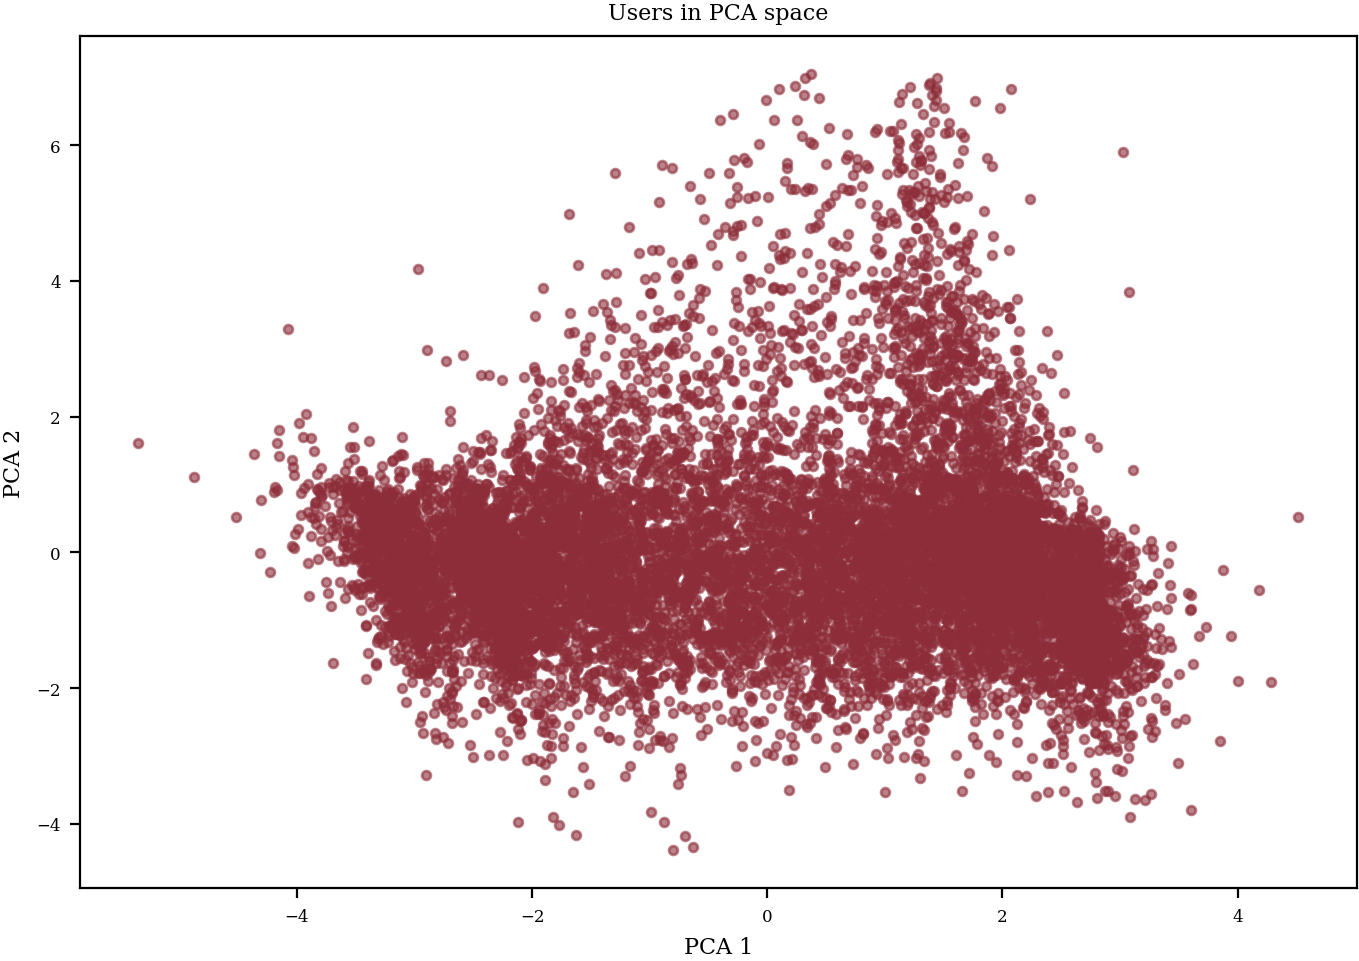

In [5]:
UNUSED_COLUMNS = {USER_ID_COL, "pca1", "pca2", "cluster", "n_loans"}

feature_cols = [
    c for c in user_features.columns
    if c not in UNUSED_COLUMNS
       and not c.endswith("_x")
       and not c.endswith("_y")
]

X = user_features[feature_cols].values
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

user_features["pca1"] = Z[:,0]
user_features["pca2"] = Z[:,1]

print("Explained variance:", pca.explained_variance_ratio_)

k = 6
km = KMeans(n_clusters=k, random_state=0, n_init="auto")
user_features["cluster"] = km.fit_predict(X)

plt.figure(figsize=(7,5))
plt.scatter(user_features["pca1"], user_features["pca2"], s=10, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Users in PCA space")
plt.tight_layout()
plt.show()

In [6]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(loadings)


                                      PC1     PC2
n_sessions                        -0.1724  0.0830
late_rate                          0.0582 -0.0972
pct_ext_ge_1                       0.0106 -0.3915
mean_loan_dur                      0.0283 -0.4109
mean_items_per_session             0.2421 -0.0997
share_media__Belletristik         -0.3385 -0.0061
share_media__Comic                 0.0856  0.5280
share_media__DVD                  -0.0928  0.0736
share_media__Kinder u. Jugend-CD   0.1765 -0.0578
share_media__Kinder u. Jugendbuch  0.4178 -0.1265
share_media__Sachbuch             -0.3109 -0.1365
share_usercat__A12                -0.3688 -0.0841
share_usercat__KIND                0.4009  0.0726
share_interest__Comic              0.0849  0.3121
share_interest__Fantastisches      0.2217 -0.1764
share_interest__Krimi             -0.2330 -0.0872
share_interest__Lustiges           0.2564 -0.1647
share_interest__Manga              0.0370  0.3922


In [7]:
cluster_profile = (
    user_features
    .groupby("cluster")[feature_cols]
    .mean()
    .T
)

overall = user_features[feature_cols].mean()

for c in sorted(user_features["cluster"].unique()):
    diff = (user_features[user_features["cluster"]==c][feature_cols].mean() - overall).sort_values(key=np.abs, ascending=False)
    print("\nCluster", c, "Top drivers:")
    print(diff.head(10))



Cluster 0 Top drivers:
n_sessions                           19.9860
mean_loan_dur                       -11.3888
share_media__DVD                      0.4743
share_media__Kinder u. Jugendbuch    -0.2763
share_usercat__KIND                  -0.2737
mean_items_per_session               -0.2551
share_usercat__A12                    0.1594
share_interest__Lustiges             -0.0867
share_interest__Fantastisches        -0.0593
share_media__Sachbuch                -0.0584
dtype: Float64

Cluster 1 Top drivers:
mean_loan_dur                       14.6526
n_sessions                          -5.5427
mean_items_per_session              -1.2288
share_media__Sachbuch                0.4416
share_usercat__KIND                 -0.3756
share_usercat__A12                   0.2995
share_media__Kinder u. Jugendbuch   -0.2660
share_interest__Krimi               -0.1158
share_interest__Lustiges            -0.1051
pct_ext_ge_1                         0.0932
dtype: Float64

Cluster 2 Top drivers:
n_sessio

## Try TSNE

/tmp/ipykernel_175125/2214772020.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


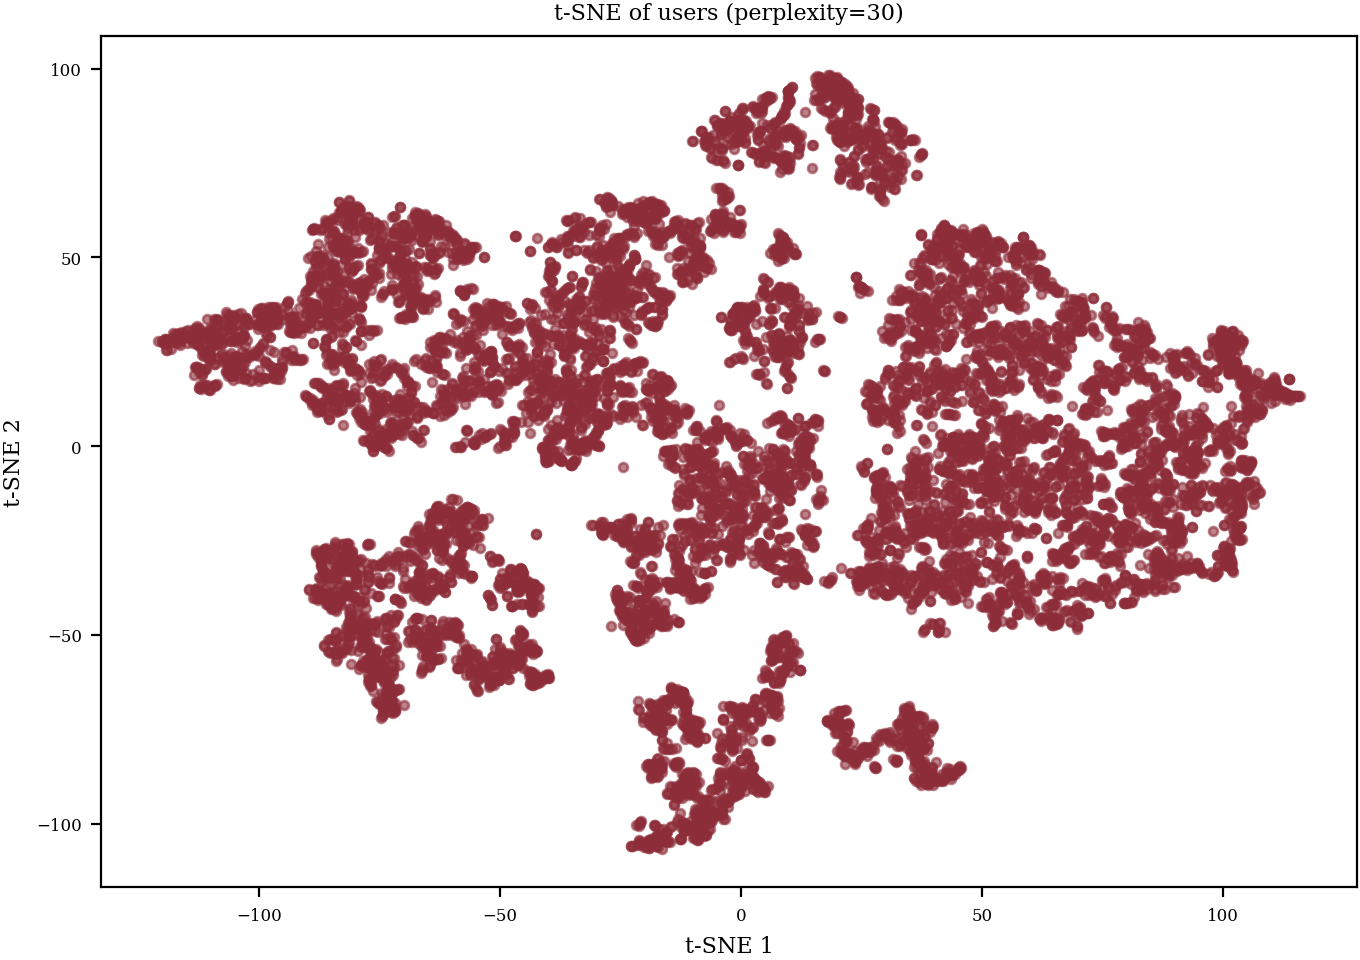

['pct_ext_ge_1',
 'mean_loan_dur',
 'mean_items_per_session',
 'share_media__Belletristik',
 'share_media__Comic',
 'share_media__DVD',
 'share_media__Kinder u. Jugend-CD',
 'share_media__Kinder u. Jugendbuch',
 'share_media__Sachbuch',
 'share_usercat__A12',
 'share_usercat__KIND',
 'share_interest__Comic',
 'share_interest__Fantastisches',
 'share_interest__Krimi',
 'share_interest__Lustiges',
 'share_interest__Manga']

In [8]:
UNUSED_COLUMNS = {
    USER_ID_COL,
    "pca1",
    "pca2",
    "cluster",
    "user",
    "n_loans",
    "n_sessions",
    "late_rate"
}
feature_cols = [
    c for c in user_features.columns
    if c not in UNUSED_COLUMNS and not c.endswith("_x") and not c.endswith("_y")
]

user_features_tsne = user_features.copy()

X = StandardScaler().fit_transform(user_features_tsne[feature_cols].values)

n = X.shape[0]
perplexity = min(30, max(5, (n - 1) // 3))
if perplexity >= n:
    perplexity = max(2, n - 1)

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="pca",
    random_state=0,
    max_iter=1500,
)

Z = tsne.fit_transform(X)

user_features_tsne["tsne1"] = Z[:, 0]
user_features_tsne["tsne2"] = Z[:, 1]

plt.figure(figsize=(7, 5))
plt.scatter(user_features_tsne["tsne1"], user_features_tsne["tsne2"], s=10, alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"t-SNE of users (perplexity={perplexity})")
plt.tight_layout()
plt.show()

display(feature_cols)


In [9]:
Z = user_features_tsne[["tsne1", "tsne2"]].to_numpy()
print(Z[:10])


[[ -23.834126   -24.967781 ]
 [  10.802741   -36.374584 ]
 [ -20.86596    -23.873676 ]
 [ -21.670437   -25.885502 ]
 [   6.6004605   -4.006818 ]
 [ -14.82151    -37.660553 ]
 [ -21.139698   -41.09188  ]
 [ -24.490524   -24.807055 ]
 [ -17.757452  -103.56513  ]
 [ -37.783142    -3.4851785]]


In [10]:
Z = user_features_tsne[["tsne1","tsne2"]].to_numpy()
db = DBSCAN(eps=3.0, min_samples=20)
user_features_tsne["tsne_cluster"] = db.fit_predict(Z)

user_features_tsne["tsne_cluster"].value_counts().head(10)

profile_cols = ["late_rate", "pct_ext_ge_1", "mean_loan_dur", "mean_items_per_session"]
cluster_profile = user_features_tsne.groupby("tsne_cluster")[profile_cols].mean().sort_index()
cluster_profile


,late_rate,pct_ext_ge_1,mean_loan_dur,mean_items_per_session
tsne_cluster,,,,
-1,0.0632,0.5241,55.5997,5.5865
0,0.0505,0.4735,41.5881,4.1105
1,0.0763,0.5558,57.5038,5.1295
2,0.0425,0.4786,47.7106,2.8915
3,0.1608,0.9025,141.4599,4.0569
...,...,...,...,...
70,0.0873,0.8411,115.3598,7.1066
71,0.0675,0.0947,32.6358,4.3597
72,0.1221,0.8167,102.8995,4.5169


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

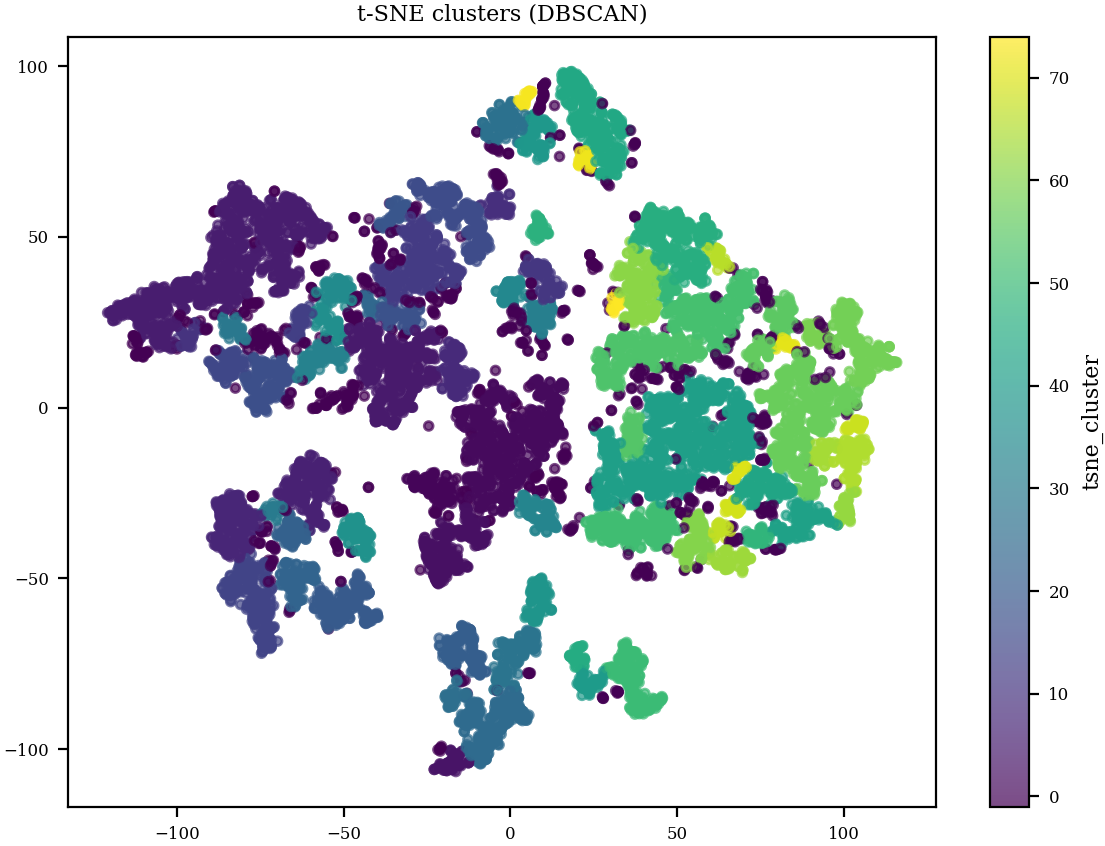

In [11]:
plt.figure(figsize=(7,5))
plt.scatter(user_features_tsne["tsne1"], user_features_tsne["tsne2"],
            c=user_features_tsne["tsne_cluster"], s=10, alpha=0.7)
plt.colorbar(label="tsne_cluster")
plt.title("t-SNE clusters (DBSCAN)")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(
    user_features_tsne["tsne1"],
    user_features_tsne["tsne2"],
    c=user_features_tsne["late_rate"],
    s=10,
    alpha=0.7
)
plt.colorbar(label="late_rate")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE (profile features) colored by late_rate")
plt.tight_layout()
plt.show()

In [ ]:
vals = user_features_tsne["late_rate"].to_numpy()

eps = 1e-4
vals_pos = np.clip(vals, eps, None)

plt.figure(figsize=(7,5))
sc = plt.scatter(
    user_features_tsne["tsne1"], user_features_tsne["tsne2"],
    c=vals_pos, s=10, alpha=0.7,
    norm=LogNorm(vmin=vals_pos.min(), vmax=vals_pos.max())
)
cb = plt.colorbar(sc)
cb.set_label("late_rate (log scale)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title("t-SNE colored by late_rate (log colorbar)")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(user_features_tsne["tsne1"], user_features_tsne["tsne2"],
            c=user_features_tsne["n_sessions"], s=10, alpha=0.7)
plt.colorbar(label="n_sessions")
plt.title("t-SNE colored by n_sessions")
plt.tight_layout()
plt.show()


In [ ]:
hot = (user_features_tsne["tsne1"].between(-5, 30)) & (user_features_tsne["tsne2"].between(0, 35))

cols = ["late_rate", "pct_ext_ge_1", "mean_ext", "mean_loan_dur", "mean_items_per_session", "n_sessions"]
print(user_features_tsne.loc[hot, cols].mean())
print(user_features_tsne.loc[~hot, cols].mean())


In [ ]:
mask = user_features_tsne["n_sessions"] >= 20
u = user_features_tsne[mask].copy()

hot = (u["tsne1"].between(-5, 30)) & (u["tsne2"].between(0, 35))
cols = ["late_rate","pct_ext_ge_1","mean_ext","mean_loan_dur","mean_items_per_session","n_sessions"]
print(u.loc[hot, cols].mean())
print(u.loc[~hot, cols].mean())
